<h2> <b>P5. </b> Building a Recommendation System with Collaborative Filtering through ALS (Alternating Least Squares) on a Subsampled Dataset <h2>

### Data gathering and preprocessing

Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

Dl dataset using Kaggle API credentials

In [2]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p ./data --unzip

import os
print("Files downloaded:", os.listdir("./data"))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 94% 1.00G/1.06G [00:10<00:02, 25.1MB/s]
100% 1.06G/1.06G [00:10<00:00, 108MB/s] 
Files downloaded: ['books_data.csv', 'Books_rating.csv']


Dataframe building

In [3]:
df = pd.read_csv("./data/Books_rating.csv")
df = df[["User_id", "profileName", "Id",  "Title", "review/score"]]
df = df.dropna()

print("Total rows:", df.shape[0])
print(df.head())

Total rows: 2437900
          User_id                         profileName          Id  \
0   AVCGYZL8FQQTD               Jim of Oz "jim-of-oz"  1882931173   
1  A30TK6U7DNS82R                       Kevin Killian  0826414346   
2  A3UH4UZ4RSVO82                        John Granger  0826414346   
3  A2MVUWT453QH61  Roy E. Perry "amateur philosopher"  0826414346   
4  A22X4XUPKF66MR     D. H. Richards "ninthwavestore"  0826414346   

                            Title  review/score  
0  Its Only Art If Its Well Hung!           4.0  
1        Dr. Seuss: American Icon           5.0  
2        Dr. Seuss: American Icon           5.0  
3        Dr. Seuss: American Icon           4.0  
4        Dr. Seuss: American Icon           4.0  


Subsampling and normalization

In [4]:
USE_SUBSAMPLE = True

if USE_SUBSAMPLE:
    # filter active users and popular books
    min_user_ratings = 20
    min_book_ratings = 20

    active_users = df['User_id'].value_counts()[lambda x: x >= min_user_ratings].index
    popular_books = df['Id'].value_counts()[lambda x: x >= min_book_ratings].index

    df_sub = df[df['User_id'].isin(active_users) & df['Id'].isin(popular_books)].copy()

    # top-N users/books
    max_users = 1000
    max_books = 1000

    top_users = df_sub['User_id'].value_counts().index[:max_users]
    top_books = df_sub['Id'].value_counts().index[:max_books]

    df_sub = df_sub[df_sub['User_id'].isin(top_users) & df_sub['Id'].isin(top_books)].copy()
else:
    df_sub = df.copy()

epsilon = np.finfo(float).eps  # smallest positive float
def minmax_user(row):
    user_ratings = row
    min_r = user_ratings.min()
    max_r = user_ratings.max()
    return ((user_ratings - min_r) / (max_r - min_r + 1e-12)) + epsilon

df_sub['rating_normalized'] = df_sub.groupby('User_id')['review/score'].transform(minmax_user)

print("Rows after subsampling:", df_sub.shape[0])
print("Number of unique users:", df_sub['User_id'].nunique())
print("Number of unique books:", df_sub['Id'].nunique())
print(df_sub[['User_id', 'review/score', 'rating_normalized']].head(5))

Rows after subsampling: 64854
Number of unique users: 995
Number of unique books: 1000
             User_id  review/score  rating_normalized
1739  A1YB29BIDULEYE           5.0       1.000000e+00
1747   AUM3YMZ0YRJE0           5.0       1.000000e+00
1761  A1FEEFAK5Y45M2           1.0       2.220446e-16
1789  A1JIPFV4OL520T           5.0       2.220446e-16
1795  A1BJLZ8UNAZX2D           3.0       5.000000e-01


Utility matrix building

In [5]:
utility_matrix = df_sub.pivot_table(
    index="User_id",
    columns="Id",
    values="review/score"
)

R = utility_matrix.fillna(0).to_numpy()
num_users, num_items = R.shape

user_index = {uid: i for i, uid in enumerate(utility_matrix.index)}
book_index = {bid: j for j, bid in enumerate(utility_matrix.columns)}

observed_idx = np.argwhere(R > 0)

print("Utility matrix shape:", R.shape)
print("Number of observed ratings:", len(observed_idx))

Utility matrix shape: (995, 1000)
Number of observed ratings: 57447


### Algorithm implementation and training

Train/test split

In [6]:
np.random.shuffle(observed_idx)
split = int(0.8 * len(observed_idx))
train_idx, test_idx = observed_idx[:split], observed_idx[split:]

R_train = np.zeros_like(R)
R_test = np.zeros_like(R)
for i, j in train_idx:
    R_train[i, j] = R[i, j]
for i, j in test_idx:
    R_test[i, j] = R[i, j]

ALS from scratch

In [7]:
def als_matrix_factorization(R_train, train_idx, R_test, test_idx, k=5, num_epochs=100, lambda_reg=0.5, verbose=False):

    num_users, num_items = R_train.shape

    # initialize w_rs ~ sqrt(avg of known elements / d)
    avg_rating = np.mean(R_train[train_idx[:,0], train_idx[:,1]])  # avg known rating
    a = np.sqrt(avg_rating / k)  # sqrt(avg/d)
    w = np.full((num_users, k), a)  # w corresponds to U
    v = np.full((num_items, k), a)  # v corresponds to V

    # RMSE computation
    def compute_rmse(R_true, W, V, idx):
        R_hat_local = W @ V.T
        diff = R_true[idx[:,0], idx[:,1]] - R_hat_local[idx[:,0], idx[:,1]]
        return np.sqrt(np.mean(diff**2))

    prev_test_rmse = np.inf  # early stopping flag

    # alternating updates per latent factor (local optimum)
    for epoch in range(num_epochs):
        # update w_rs (users)
        for r in range(num_users):
            for s in range(k):
                numerator, denominator = 0.0, 0.0
                for j in range(num_items):
                    if R_train[r,j] != 0:
                        # P_rj = sum_{k!=s} w_rk * v_kj + w_rs * v_sj
                        pred_others = sum(w[r,kk] * v[j,kk] for kk in range(k) if kk != s)
                        numerator += (R_train[r,j] - pred_others) * v[j,s]  # x formula
                        denominator += v[j,s]**2
                w[r,s] = numerator / (denominator + lambda_reg)

        # update v_sj (items)
        for j in range(num_items):
            for s in range(k):
                numerator, denominator = 0.0, 0.0
                for i in range(num_users):
                    if R_train[i,j] != 0:
                        pred_others = sum(w[i,kk] * v[j,kk] for kk in range(k) if kk != s)
                        numerator += (R_train[i,j] - pred_others) * w[i,s]  # y formula
                        denominator += w[i,s]**2
                v[j,s] = numerator / (denominator + lambda_reg)

        # compute RMSE for convergence monitoring
        train_rmse = compute_rmse(R_train, w, v, train_idx)
        test_rmse = compute_rmse(R_test, w, v, test_idx)
        if verbose:
            print(f"Epoch {epoch}: Train RMSE={train_rmse:.4f}, Test RMSE={test_rmse:.4f}")

        # early stopping when overfit occurs
        if test_rmse > prev_test_rmse:
            if verbose:
                print("Test RMSE increased, stopping early to prevent overfitting")
            break
        prev_test_rmse = test_rmse

    # final predicted matrix
    R_hat = w @ v.T

    return w, v, R_hat

Hyperparameter tuning (k, lr) based on test RMSE (may take ~6min)


Best params: k=10, lambda=1, epochs=5 with Test RMSE=0.7006


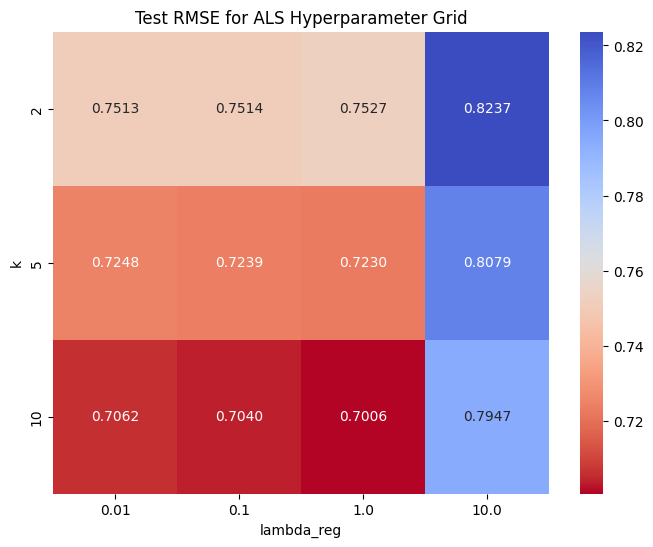

In [8]:
def tune_als_hyperparams_grid(R_train, train_idx, R_test, test_idx, k_list, lambda_list, num_epochs_list):
    best_test_rmse = np.inf
    best_result = None
    results_grid = []

    for k in k_list:
        for lambda_reg in lambda_list:
            for num_epochs in num_epochs_list:
                w, v, R_hat = als_matrix_factorization(R_train, train_idx, R_test, test_idx,
                                                       k=k, lambda_reg=lambda_reg, num_epochs=num_epochs, verbose=False)

                # compute final test RMSE
                test_diff = R_test[test_idx[:,0], test_idx[:,1]] - R_hat[test_idx[:,0], test_idx[:,1]]
                test_rmse = np.sqrt(np.mean(test_diff**2))

                results_grid.append((k, lambda_reg, num_epochs, test_rmse))

                # store best
                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                    best_result = {
                        "k": k,
                        "lambda_reg": lambda_reg,
                        "num_epochs": num_epochs,
                        "w": w,
                        "v": v,
                        "R_hat": R_hat,
                        "test_rmse": test_rmse
                    }

    print(f"\nBest params: k={best_result['k']}, lambda={best_result['lambda_reg']}, "
          f"epochs={best_result['num_epochs']} with Test RMSE={best_result['test_rmse']:.4f}")

    # plot
    df_grid = pd.DataFrame(results_grid, columns=["k", "lambda_reg", "num_epochs", "test_rmse"])
    heatmap_data = df_grid.pivot(index="k", columns="lambda_reg", values="test_rmse")

    plt.figure(figsize=(8,6))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm_r")
    plt.title("Test RMSE for ALS Hyperparameter Grid")
    plt.xlabel("lambda_reg")
    plt.ylabel("k")
    plt.show()

    return best_result, df_grid


k_list = [2, 5, 10]
lambda_list = [0.01, 0.1, 1, 10]
num_epochs_list = [5]

best_result, df_grid = tune_als_hyperparams_grid(R_train, train_idx, R_test, test_idx,
                                                 k_list, lambda_list, num_epochs_list)

Training on the best parameters (may take ~10min)

In [10]:
best_k = best_result['k']
best_lambda = best_result['lambda_reg']

w_best, v_best, R_hat_best = als_matrix_factorization(
    R_train, train_idx, R_test, test_idx,
    k=best_k,
    lambda_reg=best_lambda,
    num_epochs=50,
    verbose=True
)

Epoch 0: Train RMSE=0.7262, Test RMSE=0.7692
Epoch 1: Train RMSE=0.6790, Test RMSE=0.7405
Epoch 2: Train RMSE=0.6462, Test RMSE=0.7251
Epoch 3: Train RMSE=0.6171, Test RMSE=0.7133
Epoch 4: Train RMSE=0.5862, Test RMSE=0.7006
Epoch 5: Train RMSE=0.5625, Test RMSE=0.6931
Epoch 6: Train RMSE=0.5414, Test RMSE=0.6873
Epoch 7: Train RMSE=0.5203, Test RMSE=0.6814
Epoch 8: Train RMSE=0.5013, Test RMSE=0.6749
Epoch 9: Train RMSE=0.4839, Test RMSE=0.6679
Epoch 10: Train RMSE=0.4678, Test RMSE=0.6611
Epoch 11: Train RMSE=0.4528, Test RMSE=0.6549
Epoch 12: Train RMSE=0.4385, Test RMSE=0.6488
Epoch 13: Train RMSE=0.4250, Test RMSE=0.6426
Epoch 14: Train RMSE=0.4125, Test RMSE=0.6364
Epoch 15: Train RMSE=0.4011, Test RMSE=0.6306
Epoch 16: Train RMSE=0.3908, Test RMSE=0.6251
Epoch 17: Train RMSE=0.3816, Test RMSE=0.6200
Epoch 18: Train RMSE=0.3732, Test RMSE=0.6152
Epoch 19: Train RMSE=0.3655, Test RMSE=0.6107
Epoch 20: Train RMSE=0.3585, Test RMSE=0.6067
Epoch 21: Train RMSE=0.3521, Test RMSE=0.603

### Evaluation

Precision, Recall, Hit Rate and Coverage at different Top-N

In [11]:
def evaluate_recommendations(R_true, R_pred, k_list=[3,5,10,20], verbose=True):
    results = {}
    for k in k_list:
        num_users, num_items = R_true.shape
        precisions, recalls, hits = [], [], []
        all_recommended_items = set()

        for u in range(num_users):
            true_items = set(np.where(R_true[u] > 0)[0])
            if not true_items:
                continue

            top_k_items = np.argsort(R_pred[u])[-k:][::-1]
            top_k_set = set(top_k_items)

            hitset = top_k_set & true_items
            precisions.append(len(hitset) / k)
            recalls.append(len(hitset) / len(true_items))
            hits.append(1 if len(hitset) > 0 else 0)
            all_recommended_items.update(top_k_set)

        results[k] = {
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "Hit Rate": np.mean(hits),
            "Coverage": len(all_recommended_items) / num_items
        }

    if verbose:
      print("Recommendation Metrics")
      print("-" * 50)
      print(f"{'k':<5}{'Precision':<12}{'Recall':<12}{'Hit Rate':<12}{'Coverage':<12}")
      for k in k_list:
          m = results[k]
          print(f"{k:<5}{m['Precision']:<12.4f}{m['Recall']:<12.4f}{m['Hit Rate']:<12.4f}{m['Coverage']:<12.4f}")

    return results

metrics = evaluate_recommendations(R_test, R_hat_best, k_list=[3,5,10,20])

Recommendation Metrics
--------------------------------------------------
k    Precision   Recall      Hit Rate    Coverage    
3    0.0128      0.0028      0.0341      0.3410      
5    0.0112      0.0059      0.0455      0.4500      
10   0.0102      0.0135      0.0703      0.6070      
20   0.0113      0.0295      0.1458      0.8040      


Comparison with random and popular baselines

In [16]:
from collections import Counter

# rand baseline
def evaluate_random_baseline(R_true, k_list=[5,10]):
    num_users, num_items = R_true.shape
    R_pred = np.random.rand(num_users, num_items)
    results = evaluate_recommendations(R_true, R_pred, k_list=k_list, verbose=False)
    return {k: results[k] for k in k_list}

# pop baseline
def evaluate_popularity_baseline(df_sub, R_true, user_index_map, book_index_map, k_list=[5,10]):
    book_pop = df_sub.groupby("Id")["review/score"].sum()
    results = {}
    for k in k_list:
        top_books = book_pop.sort_values(ascending=False).index[:k]

        num_users, num_items = R_true.shape
        R_pred = np.zeros((num_users, num_items))
        for b in top_books:
            if b in book_index_map:
                R_pred[:, book_index_map[b]] = 1

        metrics = evaluate_recommendations(R_true, R_pred, k_list=[k], verbose=False)[k]
        results[k] = metrics

    return results

def compare_with_baselines(R_true, R_pred, df_sub, user_index_map, book_index_map, k_list=[5,10]):
    als_results = evaluate_recommendations(R_true, R_pred, k_list=k_list, verbose=False)
    rand_results = evaluate_random_baseline(R_true, k_list=k_list)
    pop_results = evaluate_popularity_baseline(df_sub, R_true, user_index_map, book_index_map, k_list=k_list)

    for k in k_list:
        print(f"\nComparison at k={k}")
        print("-" * 50)
        print(f"{'Metric':<12}{'ALS':<10}{'Random':<10}{'Popularity':<10}")
        for metric in ["Precision", "Recall", "Hit Rate", "Coverage"]:
            print(f"{metric:<12}{als_results[k][metric]:<10.4f}{rand_results[k][metric]:<10.4f}{pop_results[k][metric]:<10.4f}")

    return als_results, rand_results, pop_results

als_metrics, rand_metrics, pop_metrics = compare_with_baselines(
    R_test, R_hat_best, df_sub, user_index, book_index, k_list=[5,10]
)


Comparison at k=5
--------------------------------------------------
Metric      ALS       Random    Popularity
Precision   0.0112    0.0105    0.0273    
Recall      0.0059    0.0037    0.0117    
Hit Rate    0.0455    0.0517    0.0962    
Coverage    0.4500    0.9950    0.0050    

Comparison at k=10
--------------------------------------------------
Metric      ALS       Random    Popularity
Precision   0.0102    0.0109    0.0292    
Recall      0.0135    0.0087    0.0258    
Hit Rate    0.0703    0.1024    0.1779    
Coverage    0.6070    1.0000    0.0100    


Latent space analysis using PCA

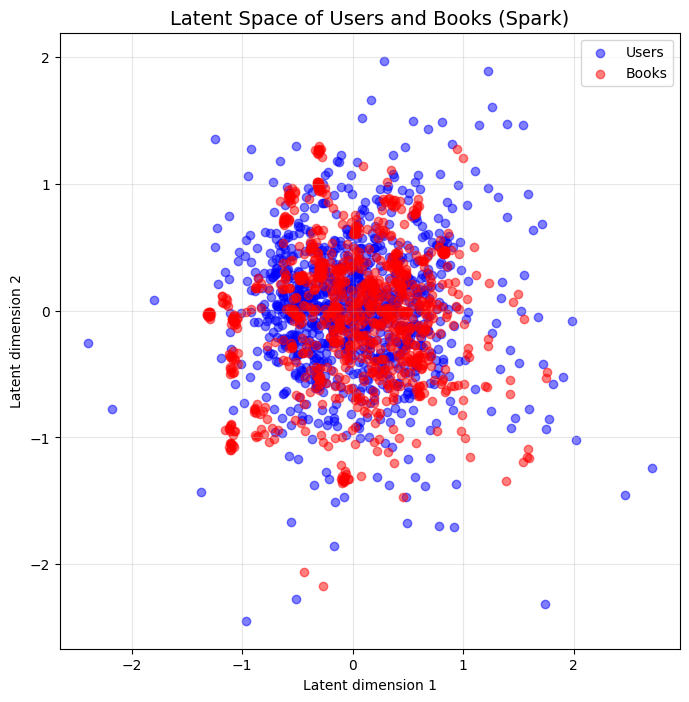

In [17]:
from sklearn.decomposition import PCA

def plot_latent_space(U, V, user_index, book_index, top_n=5):

    combined = np.vstack([U, V])
    proj = PCA(n_components=2).fit_transform(combined)

    U_proj = proj[:U.shape[0], :]
    V_proj = proj[U.shape[0]:, :]

    plt.figure(figsize=(8, 8))
    plt.scatter(U_proj[:,0], U_proj[:,1], alpha=0.5, color="blue", label="Users")
    plt.scatter(V_proj[:,0], V_proj[:,1], alpha=0.5, color="red", label="Books")

    plt.title("Latent Space of Users and Books (Spark)", fontsize=14)
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_latent_space(w_best, v_best, user_index, book_index)

Recommendation graph analysis using Louvain Algorithm

In [18]:
book_id_to_title = dict(zip(df["Id"], df["Title"]))
book_id_to_title = {bid: book_id_to_title[bid] for bid in book_index if bid in book_id_to_title}

user_id_to_name = dict(zip(df["User_id"], df["profileName"]))
user_id_to_name = {uid: user_id_to_name[uid] for uid in user_index if uid in user_id_to_name}

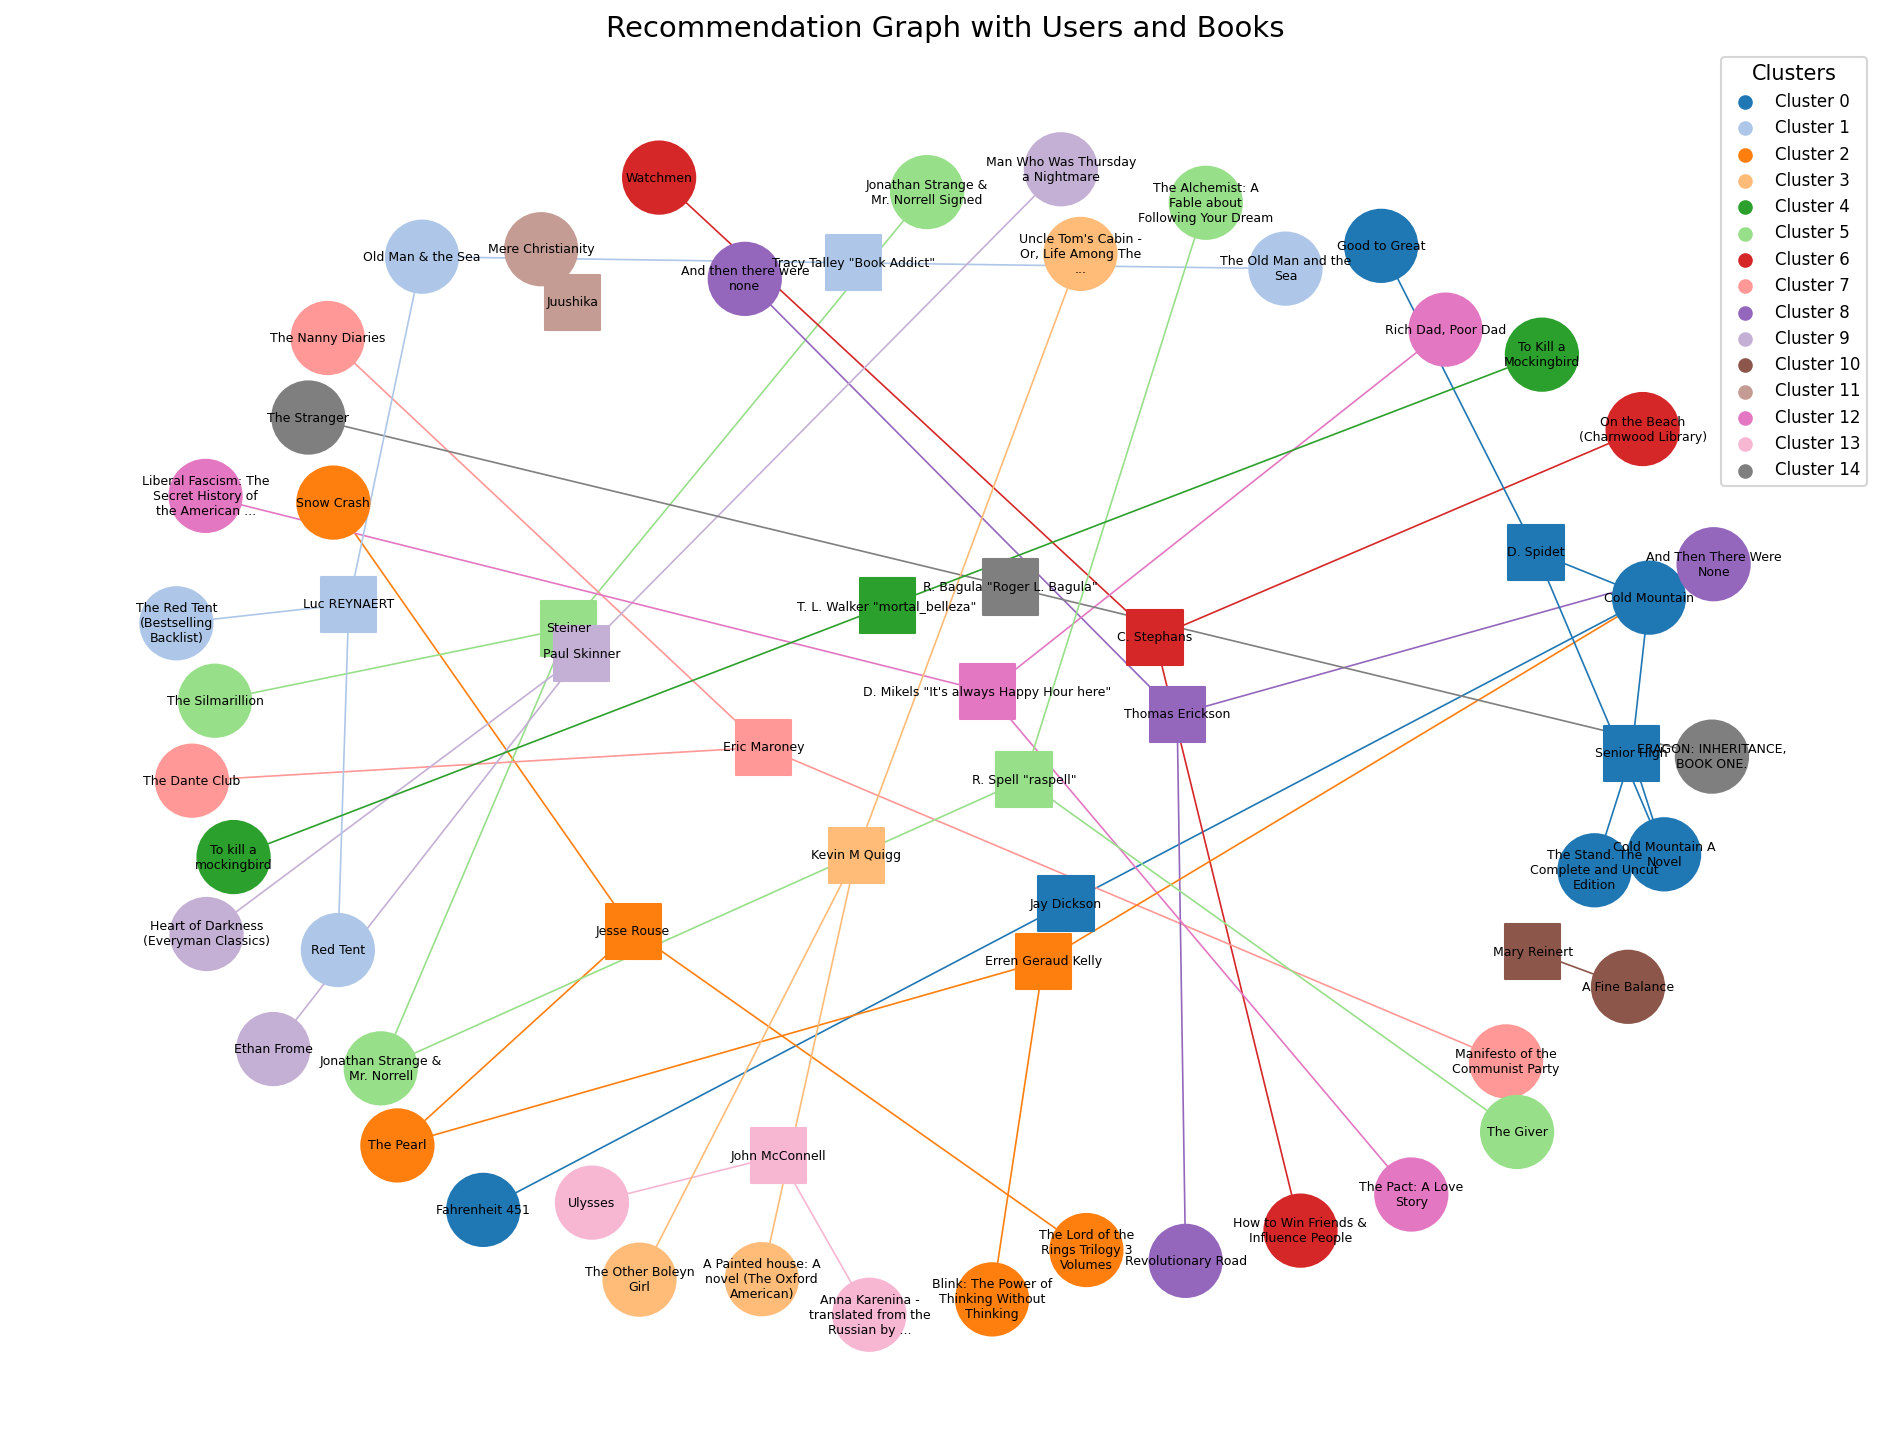

Top central books: [('Cold Mountain', 0.06349206349206349), ('Old Man & the Sea', 0.031746031746031744), ('The Pearl', 0.031746031746031744), ('Jonathan Strange &\nMr. Norrell', 0.031746031746031744), ('Cold Mountain A\nNovel', 0.031746031746031744)]


In [21]:
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import textwrap
import numpy as np

def build_recommendation_graph(R_hat, user_index, book_index, book_id_to_title, user_id_to_name, top_users=20, top_n_books=5, max_words=8, wrap_width=20):
    G = nx.DiGraph()

    user_ids = list(user_index.keys())[:top_users]
    book_ids = list(book_index.keys())

    for u in user_ids:
        u_idx = user_index[u]
        user_label = user_id_to_name.get(u, str(u))

        top_books_idx = np.argsort(R_hat[u_idx, :])[-top_n_books:][::-1]
        for b_idx in top_books_idx:
            b_id = book_ids[b_idx]
            book_title = book_id_to_title.get(b_id, str(b_id))
            words = book_title.split()
            if len(words) > max_words:
                book_title = " ".join(words[:max_words]) + " ..."
            book_title_wrapped = "\n".join(textwrap.wrap(book_title, wrap_width))
            G.add_edge(user_label, book_title_wrapped)

    return G

def plot_recommendation_graph(G, user_labels=None):
    G_undirected = G.to_undirected()
    partition = community_louvain.best_partition(G_undirected)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(16,12), dpi=150)

    node_shapes = {}
    for node in G.nodes():
        node_shapes[node] = 's' if node in user_labels else 'o'

    for shape in set(node_shapes.values()):
        shaped_nodes = [n for n in G.nodes() if node_shapes[n]==shape]
        sizes = 700 if shape=='s' else 1200
        colors = [plt.cm.tab20(partition[n] % 20) for n in shaped_nodes]
        nx.draw_networkx_nodes(G, pos, nodelist=shaped_nodes, node_color=colors,
                               node_shape=shape, node_size=sizes)

    edge_colors = []
    for u, v in G.edges():
        edge_colors.append(plt.cm.tab20(partition.get(u, 0) % 20))
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=0.8, arrowsize=12)

    nx.draw_networkx_labels(G, pos, font_size=6)

    unique_clusters = set(partition.values())
    for cluster in unique_clusters:
        plt.scatter([], [], c=[plt.cm.tab20(cluster % 20)], label=f'Cluster {cluster}')
    plt.legend(scatterpoints=1, fontsize=8, title="Clusters")

    plt.title("Recommendation Graph with Users and Books", fontsize=14)
    plt.axis('off')
    plt.show()

    return partition

def top_central_books(G, top_n=5, user_labels=None):
    degree_centrality = nx.degree_centrality(G)
    books = [(node, score) for node, score in degree_centrality.items() if node not in user_labels]
    top_books = sorted(books, key=lambda x: x[1], reverse=True)[:top_n]
    return top_books

top_users = 20
user_labels_subset = [user_id_to_name.get(uid, str(uid)) for uid in list(user_index.keys())[:top_users]]

G = build_recommendation_graph(R_hat_best, user_index, book_index, book_id_to_title, user_id_to_name,
                               top_users=top_users, top_n_books=3)

partition = plot_recommendation_graph(G, user_labels=user_labels_subset)

print("Top central books:", top_central_books(G, top_n=5, user_labels=user_labels_subset))